In [20]:
import pandas as pd

In [23]:
data = pd.read_csv('Documents/aimms_dae data.csv', index_col='store_number')
data

,total_cost,staff_cost,non-staff_cost,age_of_store,competition,customer_service,revenue
store_number,,,,,,,
1,1310,238,1072,18,11,8,1419
2,2091,459,1632,46,12,8,3064
3,930,154,776,36,9,5,987
4,3591,795,2796,34,9,7,3603
5,2729,571,2158,35,13,9,2742
6,2030,497,1533,57,7,6,2536
7,3247,558,2689,36,5,9,4320
8,2501,571,1930,40,12,7,3495
9,2299,407,1892,17,8,8,2561


In [24]:
data.describe()

,total_cost,staff_cost,non-staff_cost,age_of_store,competition,customer_service,revenue
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2265.666667,454.300000,1811.366667,32.133333,10.666667,6.933333,2400.733333
std,789.606944,178.839583,629.777327,13.818362,5.658886,1.910648,1009.507150
min,930.000000,154.000000,776.000000,4.000000,4.000000,3.000000,810.000000
25%,1673.000000,318.500000,1342.250000,21.500000,7.000000,6.000000,1639.750000
50%,2270.500000,458.500000,1816.000000,34.000000,9.000000,7.000000,2211.000000
75%,2750.750000,567.750000,2237.500000,39.500000,12.000000,8.000000,3234.000000
max,3591.000000,825.000000,2796.000000,59.000000,29.000000,10.000000,4320.000000


In [25]:
data.corr()

,total_cost,staff_cost,non-staff_cost,age_of_store,competition,customer_service,revenue
total_cost,1.000000,0.916499,0.993527,0.331259,-0.134050,0.355061,0.825439
staff_cost,0.916499,1.000000,0.865123,0.465554,-0.109987,0.410282,0.820869
non-staff_cost,0.993527,0.865123,1.000000,0.283124,-0.136837,0.328662,0.801820
age_of_store,0.331259,0.465554,0.283124,1.000000,0.265173,0.155770,0.507149
competition,-0.134050,-0.109987,-0.136837,0.265173,1.000000,-0.343377,-0.163307
customer_service,0.355061,0.410282,0.328662,0.155770,-0.343377,1.000000,0.486068
revenue,0.825439,0.820869,0.801820,0.507149,-0.163307,0.486068,1.000000


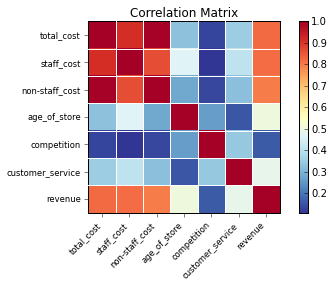

In [26]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

#For some reason I need to assign the plot function to a name or I get double figures
fig = sm.graphics.plot_corr(abs(data.corr()), xnames=data.columns.tolist())

In [7]:
from coopr import pyomo

In [16]:
%%writefile dae.py
from __future__ import division
from coopr import pyomo

model = pyomo.AbstractModel()

#Sets

model.dmu = pyomo.Set() #Store number
model.input_category = pyomo.Set() #first
model.output_category = pyomo.Set()

#Parameters

model.input_level = pyomo.Param(model.dmu, model.input_category, initialize=data['Total Cost'].tolist())
model.output_level = pyomo.Param(model.dmu, model.output_category, initialize=data.Revenue.tolist())

#Decision Variables

model.input_weight = pyomo.Var(model.dmu, model.input_category,
                               within=pyomo.NonNegativeReals)
model.output_weight = pyomo.Var(model.dmu, model.output_category,
                                within=pyomo.NonNegativeReals)


#Constraints

def ratio_of_one_rule(model,  d):
    return ((sum(model.output_level[j] * model.output_weight[j] for j in model.output_category))
             <= (sum(model.input_level[d] * model.input_weight[d] for d in model.input_category)))

model.ratio_on_one = pyomo.Constraint(rule=ratio_of_one_rule)

def sum_of_inputs_constraint_rule(model):
    return (pyomo.summation(model.input_level, model.input_weight) == 1.)

model.sum_of_inputs_constraint = pyomo.Constraint(model.dmu, rule=sum_of_inputs_constraint_rule)

def objective_rule(model):
    return pyomo.summation(model.output_level, model.output_weight)

model.objective = pyomo.Objective(model.output_category, rule=objective_rule, sense=pyomo.maximize)




#import 'Documents/aimms_dae data.csv' : 

Overwriting dae.py


In [19]:
!pyomo dae.py --solver=glpk 

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
ERROR: Unexpected exception while loading model dae.py:
	name 'data' is not defined


In [9]:
model.Z = Set()
model.Y = Param(model.Z)
model.W = Param(model.Z)

import /Documents/aimms_dae data.csv : dmu=[Store Number] Y=D W=C;

SyntaxError: invalid syntax (<ipython-input-9-79c588a2654e>, line 5)

In [ ]:
set dmu := 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 ;
    
set input_category : = total_cost ;
    
set output_category: = revenue ;
    
param 
1 
2 
3 
4 
5 
6
7 
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [ ]:
[x for x in range(1, 31)]

In [15]:
data['Total Cost'].tolist()

[1310,
 2091,
 930,
 3591,
 2729,
 2030,
 3247,
 2501,
 2299,
 2413,
 1450,
 2758,
 1857,
 3195,
 3505,
 1408,
 1127,
 1637,
 2305,
 1781,
 3122,
 2597,
 1817,
 3483,
 1954,
 1120,
 1408,
 3420,
 2242,
 2643]